# **Active Learning on Comma10K dataset** 

# Installing Dependencies

In [ ]:
# install lightly
!pip install lightly
!pip install pyyaml==5.1
# Install detectron2 that matches the above pytorch version
!pip install detectron2 -f https://dl.fbaipublicfiles.com/detectron2/wheels/$CUDA_VERSION/torch$TORCH_VERSION/index.html

# Getting Data

In [ ]:
%%time
!git clone https://github.com/commaai/comma10k

Cloning into 'comma10k'...
remote: Enumerating objects: 66689, done.
remote: Counting objects: 100% (339/339), done.
remote: Compressing objects: 100% (322/322), done.
remote: Total 66689 (delta 69), reused 261 (delta 17), pack-reused 66350
Receiving objects: 100% (66689/66689), 10.74 GiB | 37.88 MiB/s, done.
Resolving deltas: 100% (8624/8624), done.
Checking out files: 100% (23800/23800), done.
CPU times: user 3.96 s, sys: 766 ms, total: 4.72 s
Wall time: 7min


# Importing libraries

In [ ]:
import tqdm, gc
# includes for lightly
import lightly
from lightly.active_learning.utils.bounding_box import BoundingBox
from lightly.active_learning.utils.object_detection_output import ObjectDetectionOutput
from lightly.active_learning.scorers import ScorerObjectDetection
from lightly.api.api_workflow_client import ApiWorkflowClient
from lightly.active_learning.agents import ActiveLearningAgent
from lightly.active_learning.config import SamplerConfig
from lightly.openapi_generated.swagger_client import SamplingMethod

# Some basic setup:
# Setup detectron2 logger
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()

# import some common libraries
import numpy as np
import os, json, cv2, random, glob
from google.colab.patches import cv2_imshow

# import some common detectron2 utilities
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog, DatasetCatalog

import torch
TORCH_VERSION = ".".join(torch.__version__.split(".")[:2])
CUDA_VERSION = torch.__version__.split("+")[-1]
print("torch: ", TORCH_VERSION, "; cuda: ", CUDA_VERSION)

# Ctreating dataset on lightly

In [ ]:
!lightly-magic token='<token_id>' dataset_id='<dataset_id>' input_dir='./comma10k/imgs/' trainer.max_epochs=0 loader.batch_size=64 loader.num_workers=2

########## Starting to embed your dataset.
Downloading: "https://storage.googleapis.com/models_boris/whattolabel-resnet18-simclr-d32-w1.0-i-085d0693.pth" to /root/.cache/torch/hub/checkpoints/whattolabel-resnet18-simclr-d32-w1.0-i-085d0693.pth
100% 42.8M/42.8M [00:01<00:00, 38.1MB/s]
Compute efficiency: 0.32: 100% 30/30 [01:01<00:00,  2.04s/it]
Embeddings are stored at /content/lightly_outputs/2021-12-06/04-09-24/embeddings.csv
########## Starting to upload your dataset to the Lightly platform.
Dataset with id 61ad8554276b620fe02631ae has 1 tags.
Uploading images (with 2 workers).
Found 1888 images already on the server, they are skipped during the upload.
0imgs [00:51, ?imgs/s]
Finished the upload of the dataset.
Starting upload of embeddings.
Appending embeddings from server.
Finished upload of embeddings.
########## Finished


In [ ]:
YOUR_TOKEN = "<token_id>"  # your token of the web platform
YOUR_DATASET_ID = "<dataset_id>"  # the id of your dataset on the web platform

# allow setting of token and dataset_id from environment variables
def try_get_token_and_id_from_env():
    token = os.getenv('TOKEN', YOUR_TOKEN)
    dataset_id = os.getenv('AL_TUTORIAL_DATASET_ID', YOUR_DATASET_ID)
    return token, dataset_id

YOUR_TOKEN, YOUR_DATASET_ID = try_get_token_and_id_from_env()

## Inference on unlabelled data using Active learning

In [ ]:
# create Lightly API client
api_client = ApiWorkflowClient(dataset_id=YOUR_DATASET_ID, token=YOUR_TOKEN)
al_agent = ActiveLearningAgent(api_client)

In [ ]:
print(al_agent.query_set[:3])

['0000_0085e9e41513078a_2018-08-19--13-26-08_11_864.png', '0001_a23b0de0bc12dcba_2018-06-24--00-29-19_17_79.png', '0002_e8e95b54ed6116a6_2018-09-05--22-04-33_2_608.png']


In [ ]:
print(len(al_agent.query_set))

1888


## Detectron2 model for prediction on new unseen images

In [ ]:
cfg = get_cfg()
# add project-specific config (e.g., TensorMask) here if you're not running a model in detectron2's core library
###cfg.merge_from_file(model_zoo.get_config_file("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml"))
cfg.merge_from_file(model_zoo.get_config_file("COCO-Detection/faster_rcnn_R_50_FPN_3x.yaml"))
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5  # set threshold for this model
# Find a model from detectron2's model zoo. You can use the https://dl.fbaipublicfiles... url as well
###cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml")
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-Detection/faster_rcnn_R_50_FPN_3x.yaml")
predictor = DefaultPredictor(cfg)

In [ ]:
def predict_and_overlay(model, fname):
  # helper method to run the model on an image and overlay the predictions
  im = cv2.imread(fname)
  out = model(im)
  # We can use `Visualizer` to draw the predictions on the image.
  v = Visualizer(im[:, :, ::-1], MetadataCatalog.get(cfg.DATASETS.TRAIN[0]), scale=1.2)
  out = v.draw_instance_predictions(out["instances"].to("cpu"))
  cv2_imshow(out.get_image()[:, :, ::-1])

In [ ]:
def convert_bbox_detectron2lightly(outputs):
    # convert detectron2 predictions into lightly format
    height, width = outputs['instances'].image_size
    boxes = []

    for (bbox_raw, score, class_idx) in zip(outputs['instances'].pred_boxes.tensor,
                                            outputs['instances'].scores,
                                            outputs['instances'].pred_classes):
        x0, y0, x1, y1 = bbox_raw.cpu().numpy()
        x0 /= width
        y0 /= height
        x1 /= width
        y1 /= height

        boxes.append(BoundingBox(x0, y0, x1, y1))
    output = ObjectDetectionOutput.from_scores(
      boxes, outputs['instances'].scores.cpu().numpy(),
      outputs['instances'].pred_classes.cpu().numpy().tolist())
    return output

## Model predictions

In [ ]:
obj_detection_outputs = []
pbar = tqdm.tqdm(al_agent.query_set)
for fname in pbar:
  fname_full = os.path.join('./comma10k/imgs/', fname)
  im = cv2.imread(fname_full)
  out = predictor(im)
  obj_detection_output = convert_bbox_detectron2lightly(out)
  obj_detection_outputs.append(obj_detection_output)

  0%|          | 0/1888 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/detectron2/structures/image_list.py:88: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  max_size = (max_size + (stride - 1)) // stride * stride
/usr/local/lib/python3.7/dist-packages/torch/functional.py:445: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  ../aten/src/ATen/native/TensorShape.cpp:2157.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]
100%|██████████| 1888/1888 [03:32<00:00,  8.87it/s]


### Prediction scores

In [ ]:
scorer = ScorerObjectDetection(obj_detection_outputs)
scores = scorer.calculate_scores()

In [ ]:
max_score = scores['uncertainty_margin'].max()
idx = scores['uncertainty_margin'].argmax()
print(f'Highest uncertainty_margin score found for idx {idx}: {max_score}')

Highest uncertainty_margin score found for idx 1395: 0.9794728755950928


/usr/local/lib/python3.7/dist-packages/detectron2/structures/image_list.py:88: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  max_size = (max_size + (stride - 1)) // stride * stride


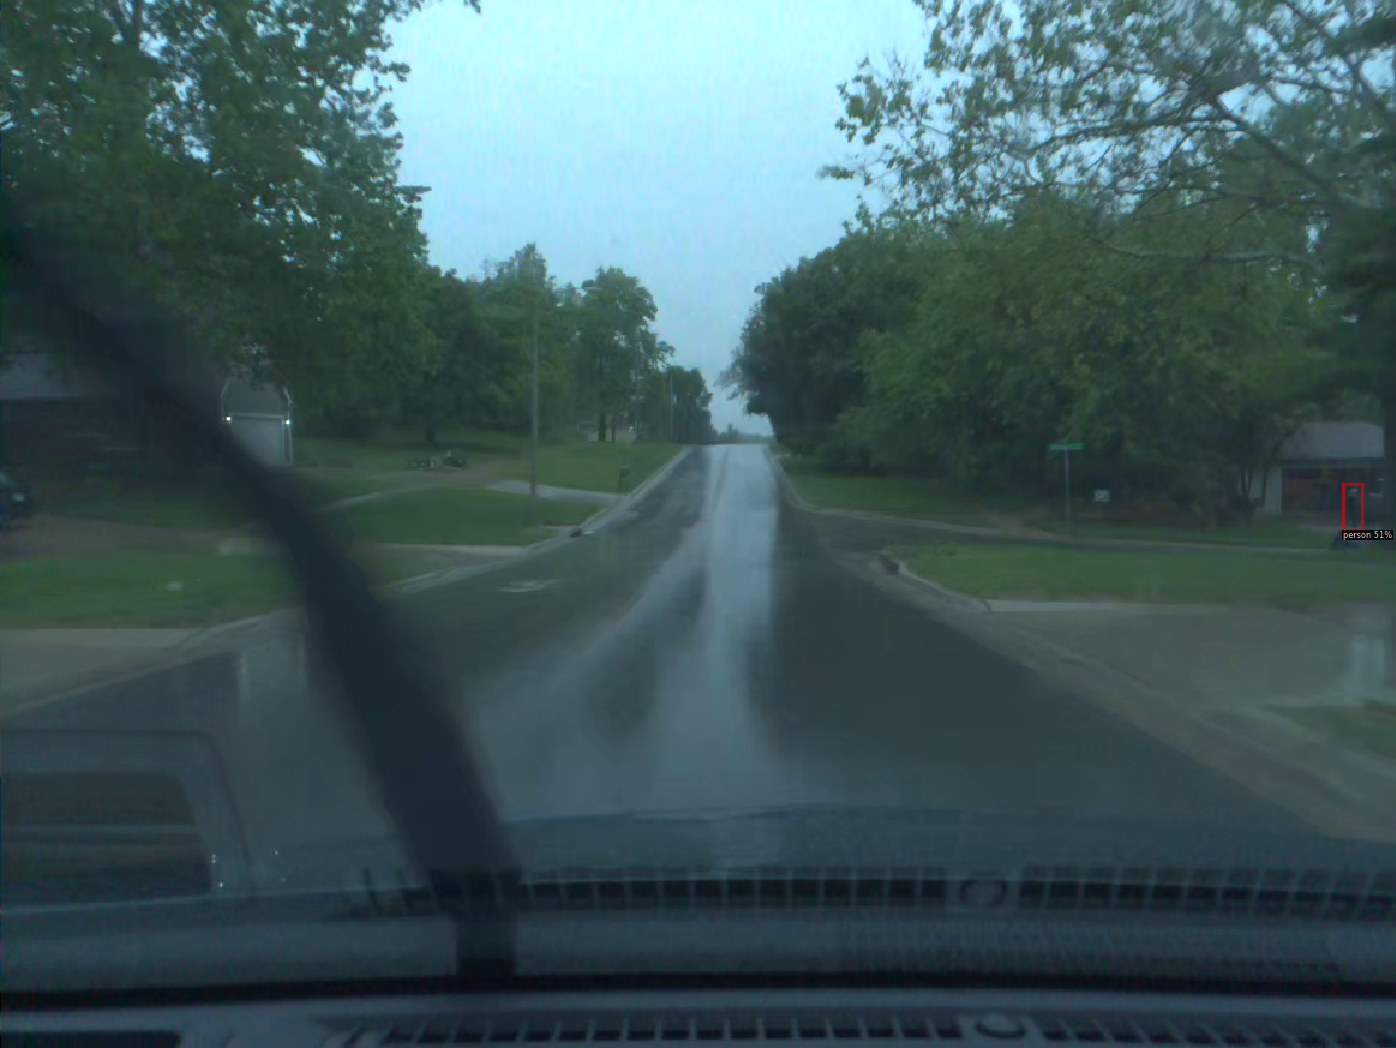

In [ ]:
fname = os.path.join('./comma10k/imgs/', al_agent.query_set[idx])
predict_and_overlay(predictor, fname)

In [ ]:
config = SamplerConfig(
  n_samples=100, 
  method=SamplingMethod.CORAL, 
  name='active-learning-loop-1'
)
al_agent.query(config, scorer)

In [ ]:
print(len(al_agent.added_set))

100


In [ ]:
al_agent.added_set[:5]

['0002_e8e95b54ed6116a6_2018-09-05--22-04-33_2_608.png',
 '0003_97a4ec76e41e8853_2018-09-29--22-46-37_5_585.png',
 '0008_b8727c7398d117f5_2018-10-22--15-38-24_71_990.png',
 '0009_ef53f1ffea65e93c_2018-07-26--03-48-48_14_191.png',
 '0153_2665ce6f7b1dce08_2018-08-26--18-15-41_16_123.png']

/usr/local/lib/python3.7/dist-packages/detectron2/structures/image_list.py:88: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  max_size = (max_size + (stride - 1)) // stride * stride


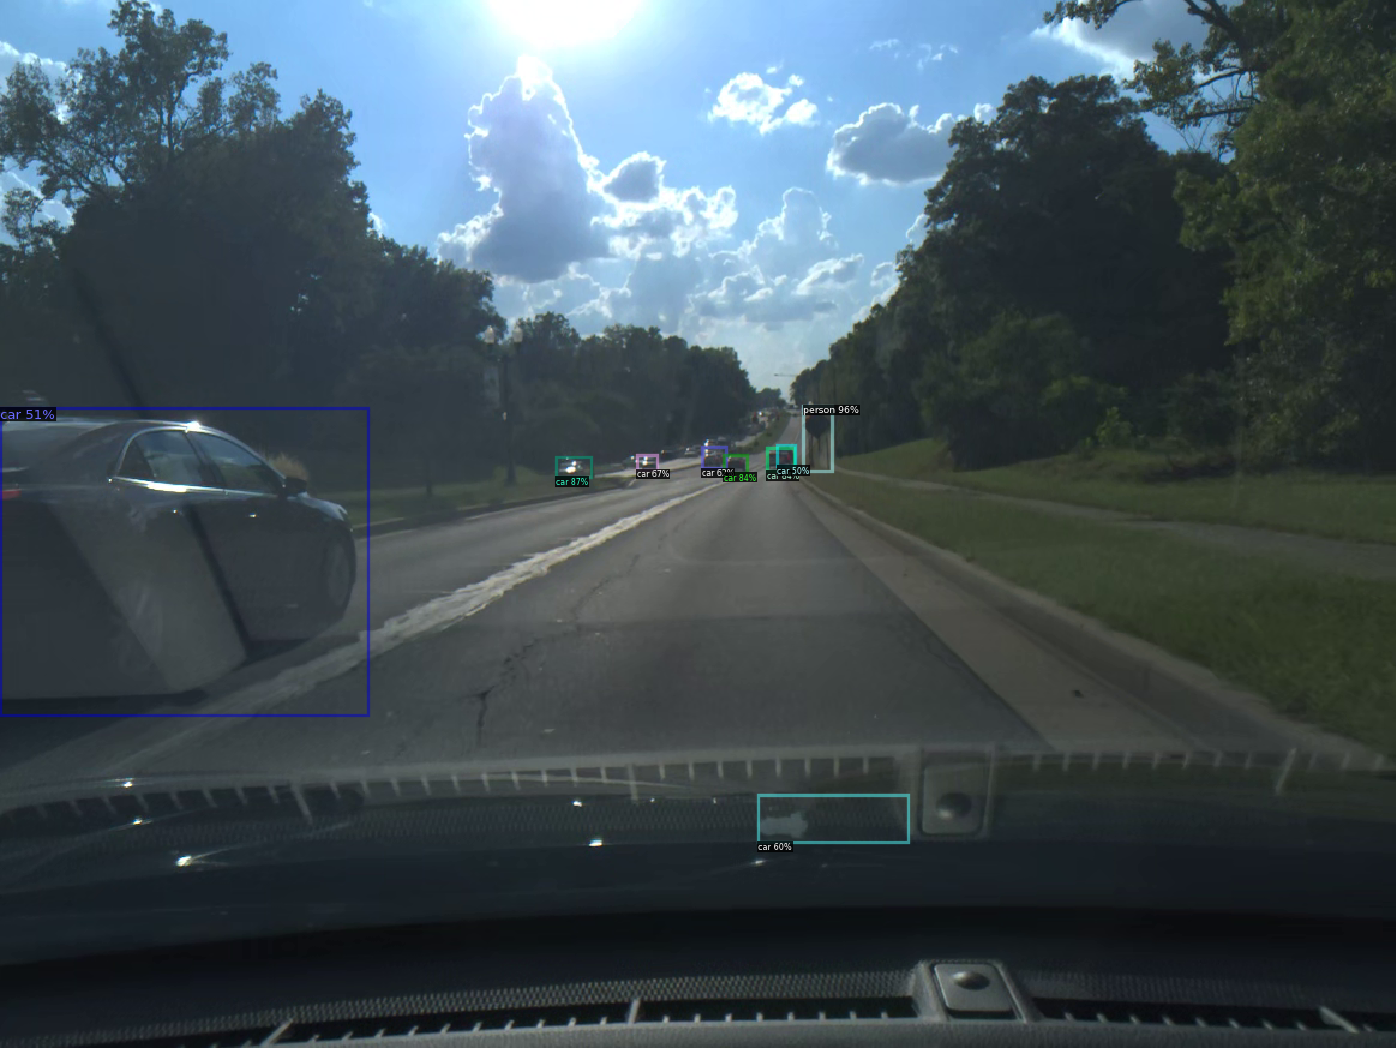

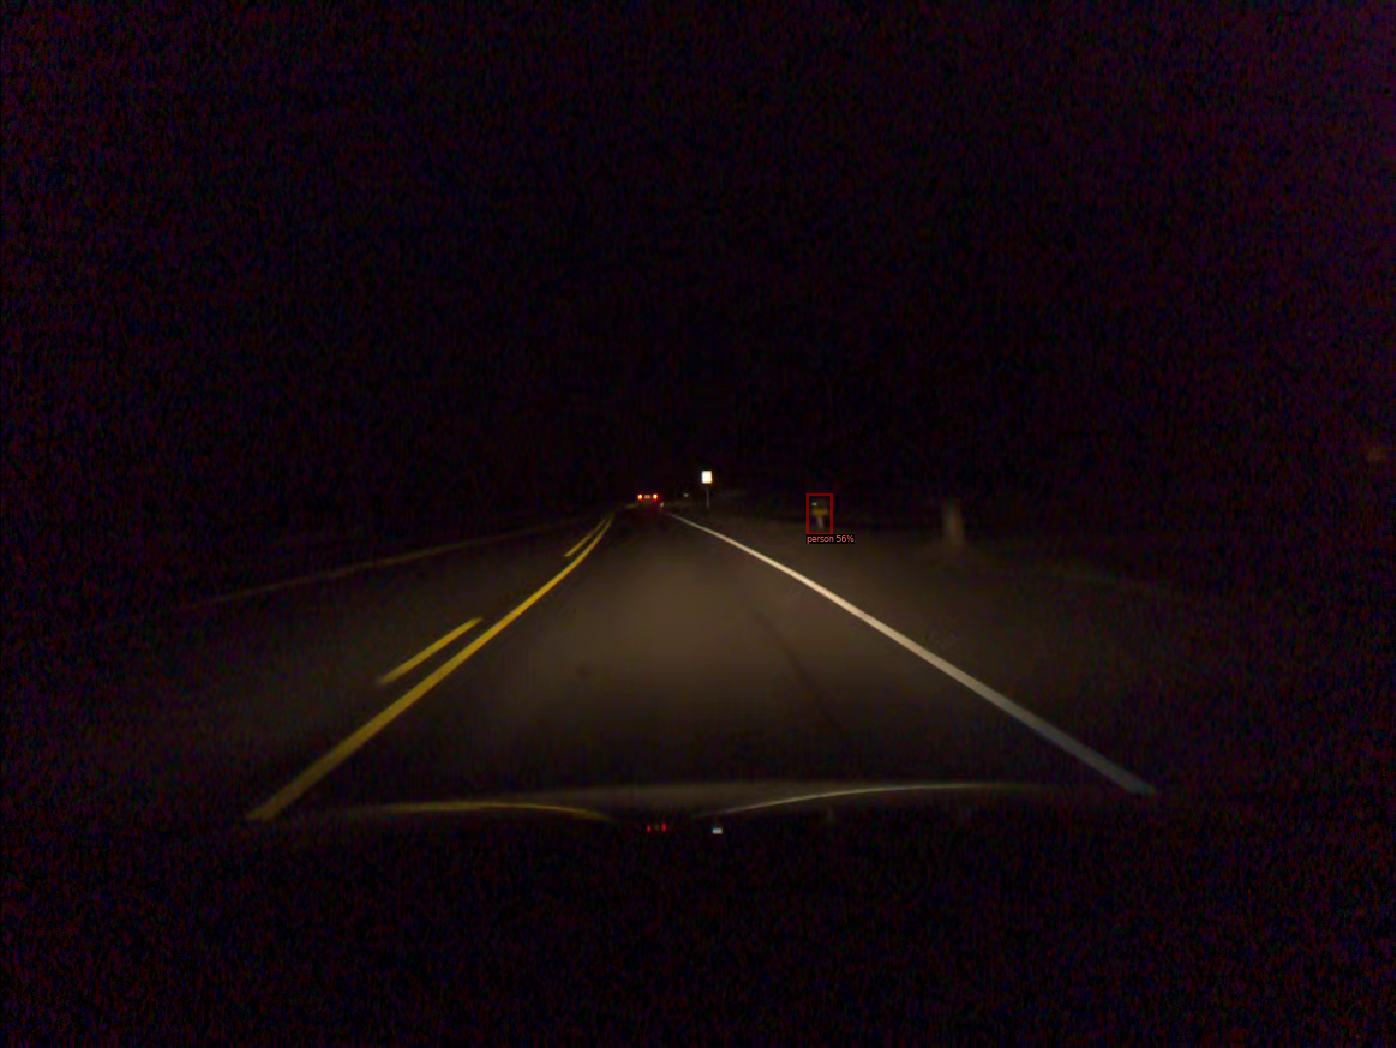

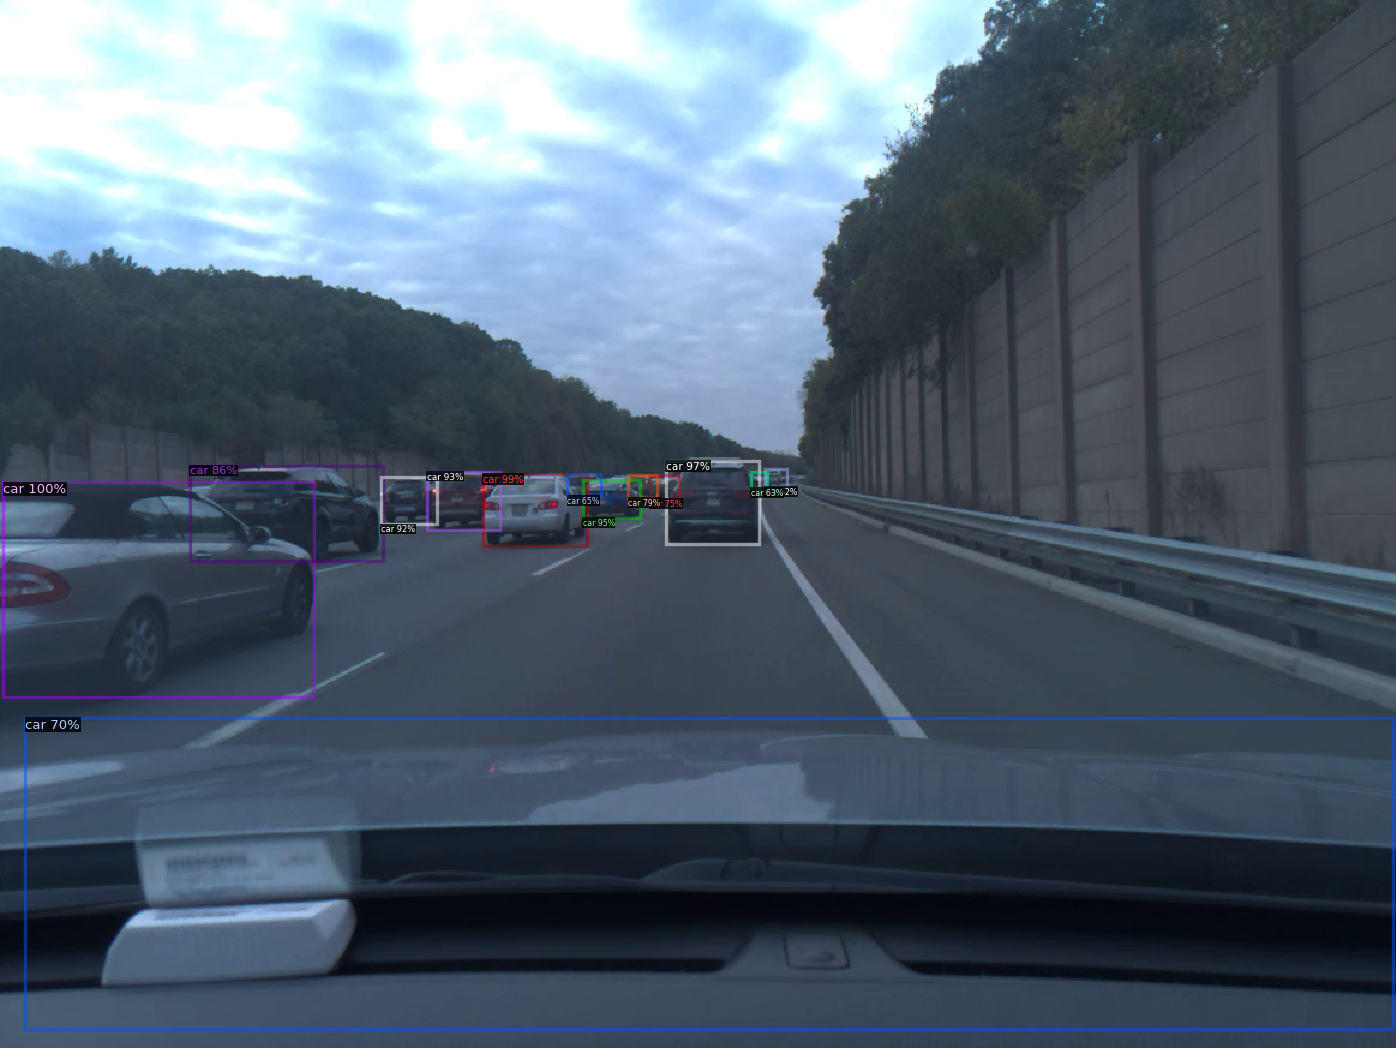

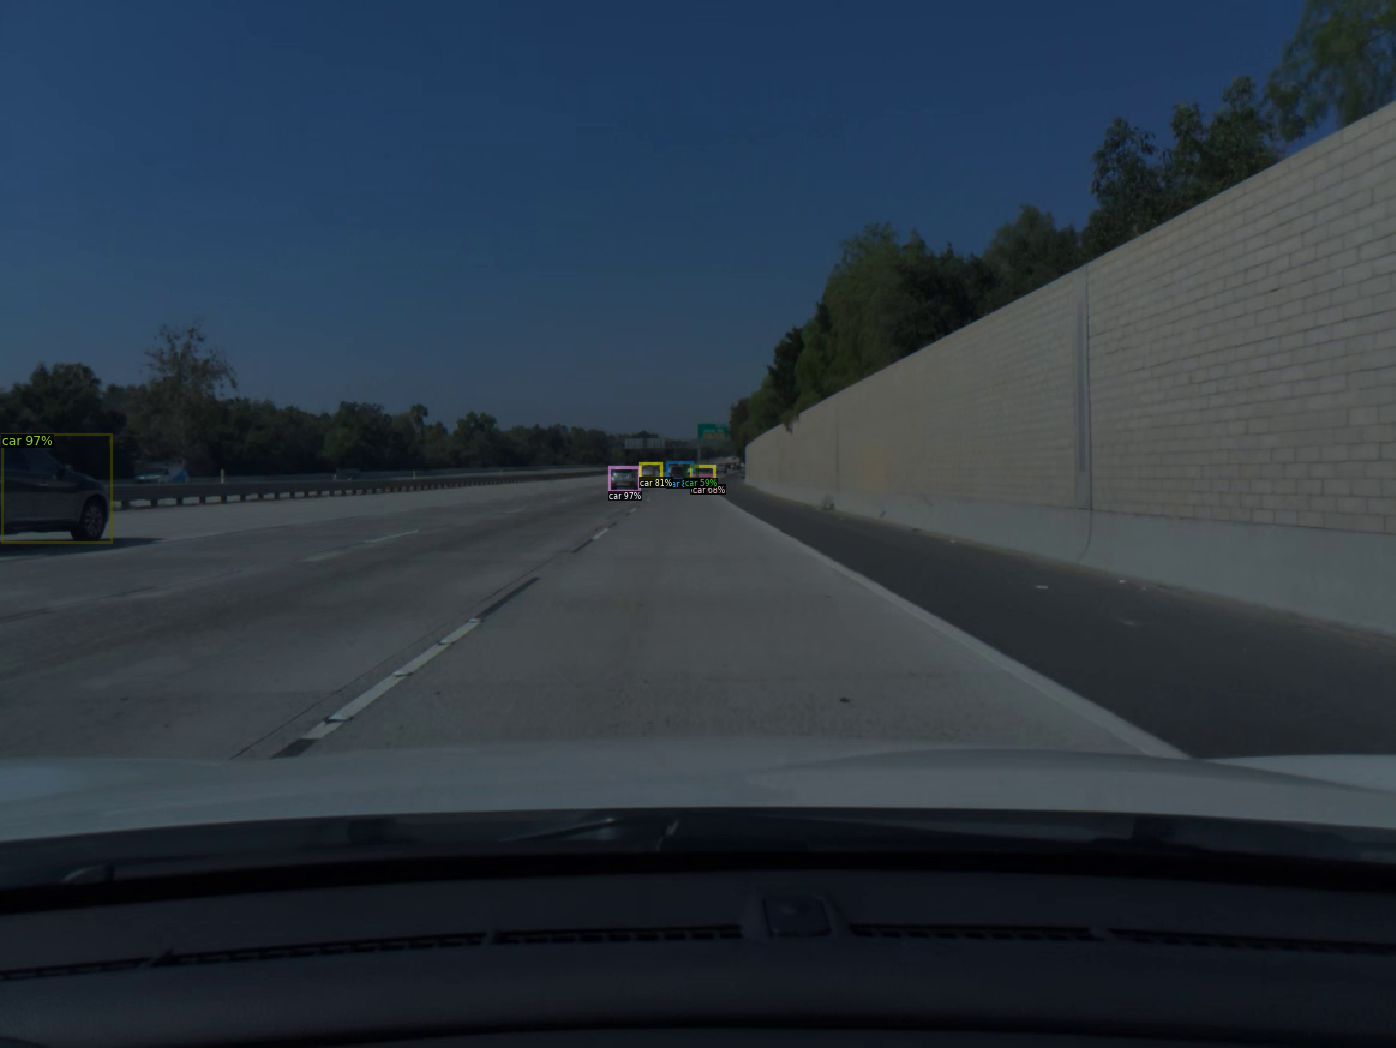

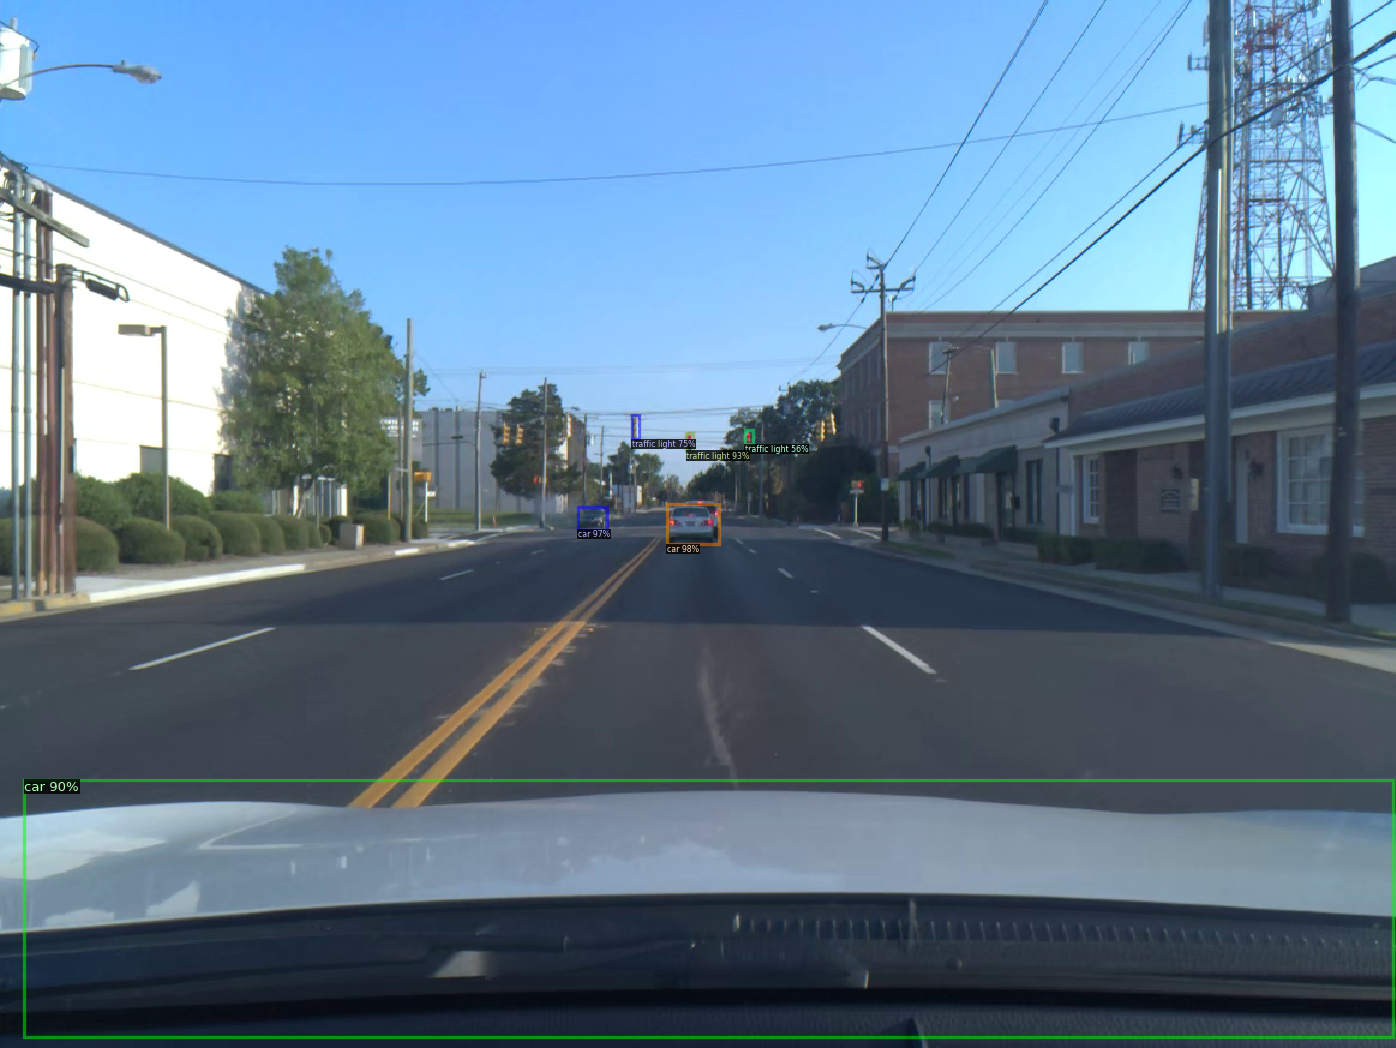

In [ ]:
to_label = [os.path.join('./comma10k/imgs/', x) for x in al_agent.added_set]
for i in range(5):
  predict_and_overlay(predictor, to_label[i])